## Match DIA Object against Gaia to reject stars

Notebook by Michael Wood-Vasey: <wmwv@pitt.edu>  
based on suggestions from Neven Caplar


Set up Python PATH to include the local directory we're going to pip install into

In [1]:
import sys
sys.path.insert(0, "/home/m/mwv/.local/lib/python3.12/site-packages/")

For setup requirements see
https://github.com/lsst-sitcom/linccf/blob/15c5528ab32a81ebf1fa20ce37b58fbd00af7e00/internal/LSSTCam_init/LINCC_bucket.ipynb

Your `.bashrc` should include

```sh
export AWS_SHARED_CREDENTIALS_FILE=~/.lsst/aws-credentials.ini
export LSST_RESOURCES_S3_PROFILE_embargo=https://sdfembs3.sdf.slac.stanford.edu
# LINCC HATS endpoint
export AWS_ENDPOINT_URL=$LSST_RESOURCES_S3_PROFILE_embargo
```

But this doesn't get picked up in the notebook, so we're going to define AWS_ENDPOINT_URL below.

and then you will need to install the following over the LSST distrib install:

```sh
pip install --user lsdb 
```

The note about the exact version of `awscli` in the link above is only if you need to upload to the bucket.  *Don't install it* here.  It's going to conflict with versions loaded for the LSST Science Pipelines and `pip` will fail to do the correct dependency resolution against the LSST Science Pipelines installed versions and overwrite things and then `s3fs` will stop working for anything in your Notebooks and everyone will be sad.

In [2]:
AWS_ENDPOINT_URL = os.getenv("LSST_RESOURCES_S3_PROFILE_embargo")

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay

import lsst.geom

import lsst.afw.image
from lsst.afw.math import Warper, WarperConfig
import lsst.afw.table

In [4]:
# Load collection
repo = "embargo_new"
# https://ls.st/campaigns
# Follow to Intermittent Processing Campaigns for Cumulative DRP.
collection = "LSSTCam/runs/DRP/FL/w_2025_19/DM-50795"

instrument = "LSSTCam"

butler = Butler(repo, collections=collection)

name_skymap = "lsst_cells_v1"
skymap = butler.get("skyMap", skymap=name_skymap, collections="skymaps")

In [5]:
## Match to Gaia, from Neven Caplar

from lsdb.core.search import ConeSearch
import lsdb
from upath import UPath

from dask.distributed import Client

# Start with a small client
client = Client(n_workers=8, memory_limit="4GB", threads_per_worker=1)

In [6]:
gaia = lsdb.read_hats("https://data.lsdb.io/hats/gaia_dr3/gaia",
                      margin_cache="https://data.lsdb.io/hats/gaia_dr3/gaia_10arcs",
                      columns=["source_id", "ra", "dec"])

radius_deg = 1
dia_object_lc = lsdb.read_hats(UPath("s3://rubin-lincc-hats/hats/w_2025_19/dia_object_collection/",
                                     endpoint_url=AWS_ENDPOINT_URL),
#                               columns="all",
                               columns=["diaObjectId", "ra", "dec", "nDiaSources", "diaSource"],

#                               columns=["diaObjectId", "ra", "dec", "nDiaSources"],
                               search_filter=ConeSearch(ra=186.26, dec=7.0, radius_arcsec=radius_deg * 3600))

In [7]:
dia_object_lc.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'diaSource'], dtype='object')

In [8]:
dia_object_lc = dia_object_lc.query("nDiaSources > 10")

# dia_object_gaia = dia_object_lc.crossmatch(gaia, suffixes=["", "_gaia"],
#                                            radius_arcsec=1)

In [9]:
dia_object_gaia = dia_object_lc.crossmatch_nested(gaia, radius_arcsec=1)

In [10]:
dia_object_good = dia_object_gaia[dia_object_gaia["gaia"].isna()]

In [11]:
dia_object_good = dia_object_good.compute()

In [14]:
dia_object_good = dia_object_good.drop(columns="gaia")

diaObjectId          ra       dec  nDiaSources  \
_healpix_29                                                                 
1950158567361949180  72588795593097992  186.392108  6.008691           14   
1950158643356786902  72589482787865035  186.424948  6.028255           13   
...                                ...         ...       ...          ...   
1950982344399404265  74239987180110631   186.16333  7.971531           15   
1950982792038911698  74239987180110705  186.107475  7.983901           14   

                                                             diaSource  
_healpix_29                                                             
1950158567361949180  [{visit: 2025042900250, detector: 143, band: '...  
1950158643356786902  [{visit: 2025042400182, detector: 140, band: '...  
...                                                                ...  
1950982344399404265  [{visit: 2025042400246, detector: 153, band: '...  
1950982792038911698  [{visit: 2025042700262, detector: 7, band: 'i'...  

[6308 rows x 5 columns]

In [17]:
dia_object_good["diaSource"]

_healpix_29
1950158567361949180    [{visit: 2025042900250, detector: 143, band: '...
1950158643356786902    [{visit: 2025042400182, detector: 140, band: '...
                                             ...                        
1950982344399404265    [{visit: 2025042400246, detector: 153, band: '...
1950982792038911698    [{visit: 2025042700262, detector: 7, band: 'i'...
Name: diaSource, Length: 6308, dtype: nested<visit: [int64], detector: [int16], band: [string], ssObjectId: [int64], parentDiaSourceId: [int64], midpointMjdTai: [double], bboxSize: [int64], time_processed: [timestamp[us]], ra: [double], dec: [double], raErr: [float], decErr: [float], ra_dec_Cov: [float], x: [double], y: [double], xErr: [float], yErr: [float], apFlux: [float], apFluxErr: [float], snr: [float], psfFlux: [float], psfFluxErr: [float], psfChi2: [float], psfNdata: [int32], trailFlux: [float], trailRa: [float], trailDec: [float], trailLength: [float], trailAngle: [float], dipoleMeanFlux: [float], dipoleMea

<ErrorbarContainer object of 3 artists>

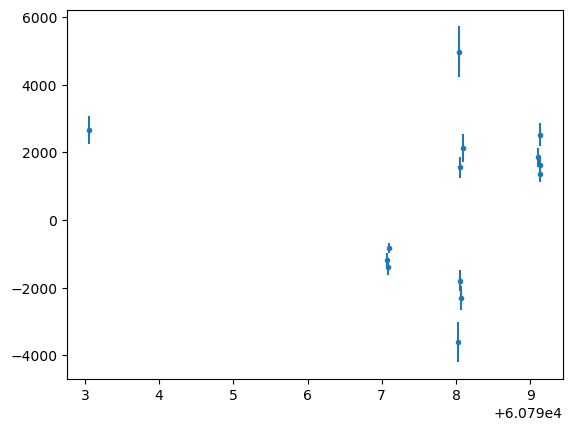

In [42]:
lc = dia_object_good.loc[1950982792038911698, "diaSource"]
plt.errorbar(lc["midpointMjdTai"], lc["psfFlux"], lc["psfFluxErr"], marker=".", linestyle="none")

Let's look at these ~20,000 DiaObjects in more detail

In [ ]:
# i = 100
# dia_object_id = dia_object_good["diaObjectId"].iloc[i]

dia_object_id, ra, dec, tract, patch = 72574914258796561, 183.75252227917093, 6.021533090472069, 10561, 4  # asteroid
dia_object_id, ra, dec, tract, patch = 72576288648331436, 183.82276515013018, 6.225434371596927, 10561, 24  # asteroid
dia_object_id, ra, dec, tract, patch = 72576426087284744, 183.42572499899103, 6.214620153481146, 10561, 26 
dia_object_id, ra, dec, tract, patch = 72576426087284754, 183.40897748640762, 6.268596546159569, 10561, 26  # chip artifact in template
dia_object_id, ra, dec, tract, patch = 72577594318389471, 183.94905319426206, 6.64130005971463, 10561, 43  # chip artifact
# dia_object_id, ra, dec, tract, patch = 72577663037866124, 183.78028178645692, 6.644479238196538, 10561, 44 
# dia_object_id, ra, dec, tract, patch = 72578350232633476, 183.89441500979382, 6.804184567307713, 10561, 54  # Asteroid, caught in several frames moving
# dia_object_id, ra, dec, tract, patch = 72579037427400819, 183.8024799558616, 6.915889343227354, 10561, 64
# dia_object_id, ra, dec, tract, patch = 72579037427400730, 183.89807037732572, 6.9626934954376445, 10561, 64  # Bright stars that saturates a little bit
# dia_object_id, ra, dec, tract, patch = 72579037427400729, 183.8909026570155, 6.965729967938901, 10561, 64  # Bright star.  Possibily truly variable
# dia_object_id, ra, dec, tract, patch = 72579037427400732, 183.7862243579003, 6.987152092427406, 10561, 64  # Asteroid

# tract_data_id = {'tract': tract, 'patch': patch, 'skymap': 'lsst_cells_v1'}

In [ ]:
i = 100
dia_object_id, ra, dec, tract_data_id = interest_candidates[i]

In [ ]:
dia_object = butler.get("dia_object", dataId=tract_data_id)
dia_object_patch = butler.get("dia_object_patch", dataId=tract_data_id)
dia_object_forced_source_patch = butler.get("dia_object_forced_source", dataId=tract_data_id)

In [ ]:
dia_object_patch.loc[dia_object_id]

In [ ]:
lc = dia_object_forced_source_patch[(dia_object_forced_source_patch["diaObjectId"] == dia_object_id)] # & \
#                                    (dia_object_forced_source_patch["band"] == "i")]

In [ ]:
# plt.errorbar(lc["visit"], lc["psfFlux"], lc["psfFluxErr"], marker=".", linestyle="none", color="blue")
plt.errorbar(lc["visit"], lc["psfDiffFlux"], lc["psfDiffFluxErr"], marker=".", linestyle="none", color="orange")
plt.ylim(-2000, +2000)

In [38]:
def cutout_coadd(butler, ra, dec, tract, patch, band, skymap, cutoutSideLength=51, dataset_type="visit_image", **kwargs):
    
    """
    Produce a cutout from an image at the given ra, dec position.

    If the cutout extends beyond the data array then an error will be triggered.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the image's visit
    detector: int
        Detector for the image
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.
    dataset_type: str
        dataset_type
        "visit_image", "template_matched", "difference_image", ...

    Returns
    -------
    MaskedImage
    """
    
    data_id = {"tract": tract, "patch": patch, "band": band, "skymap": skymap}
    radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    cutoutSize = lsst.geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    wcs = butler.get(dataset_type+".wcs", **data_id)
    xy = lsst.geom.PointI(wcs.skyToPixel(radec))
    bbox = lsst.geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get(dataset_type, parameters=parameters, **data_id)

    return cutout_image

In [39]:
def cutout_image(butler, ra, dec, visit, detector, cutoutSideLength=51, dataset_type="visit_image", **kwargs):
    
    """
    Produce a cutout from an image at the given ra, dec position.

    If the cutout extends beyond the data array then an error will be triggered.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the image's visit
    detector: int
        Detector for the image
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.
    dataset_type: str
        dataset_type
        "visit_image", "template_matched", "difference_image", ...

    Returns
    -------
    MaskedImage
    """
    
    data_id = {"visit": visit, "detector": detector}    
    radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    cutoutSize = lsst.geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    wcs = butler.get(dataset_type+".wcs", **data_id)
    xy = lsst.geom.PointI(wcs.skyToPixel(radec))
    bbox = lsst.geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get(dataset_type, parameters=parameters, **data_id)

    return cutout_image

In [40]:
afwDisplay.setDefaultBackend("matplotlib")

visit            2025042900250
detector                   143
                     ...      
scienceMag           18.391594
scienceMagErr         0.002216
Name: 0, Length: 91, dtype: object
2025042900250 143
(1819, 672)
(minimum=(1794, 647), maximum=(1844, 697))
visit            2025050100298
detector                   146
                     ...      
scienceMag           17.365692
scienceMagErr         0.001433
Name: 1, Length: 91, dtype: object
2025050100298 146
(375, 807)
(minimum=(350, 782), maximum=(400, 832))
visit            2025050100374
detector                   139
                     ...      
scienceMag           19.280695
scienceMagErr         0.003413
Name: 2, Length: 91, dtype: object
2025050100374 139
(3346, 2937)
(minimum=(3321, 2912), maximum=(3371, 2962))
visit            2025050100446
detector                   150
                     ...      
scienceMag           19.211384
scienceMagErr         0.003633
Name: 3, Length: 91, dtype: object
2025050100446 150
(31

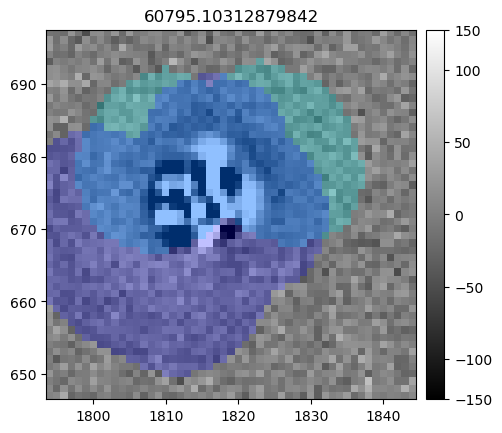

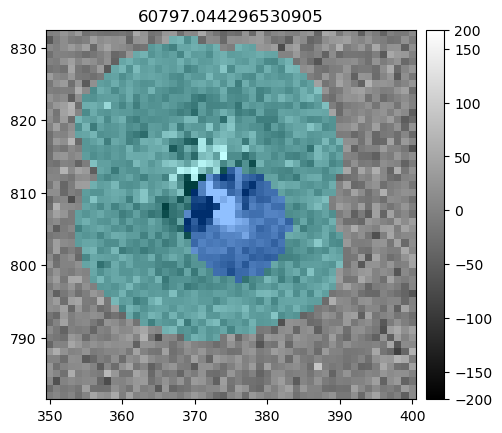

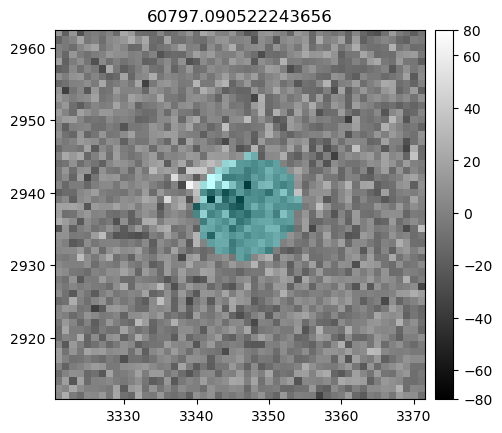

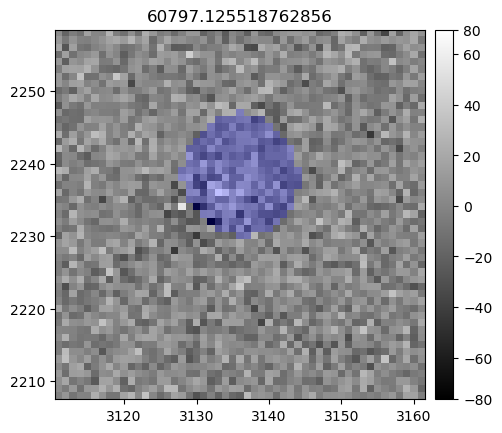

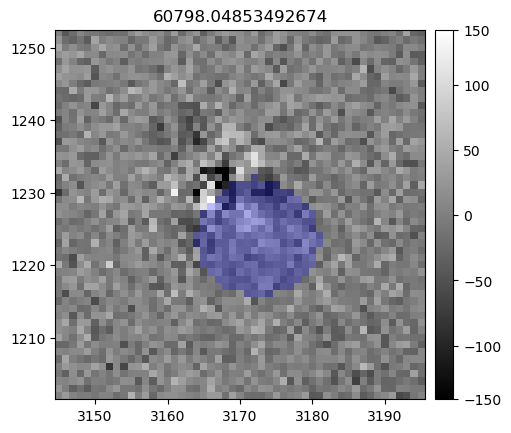

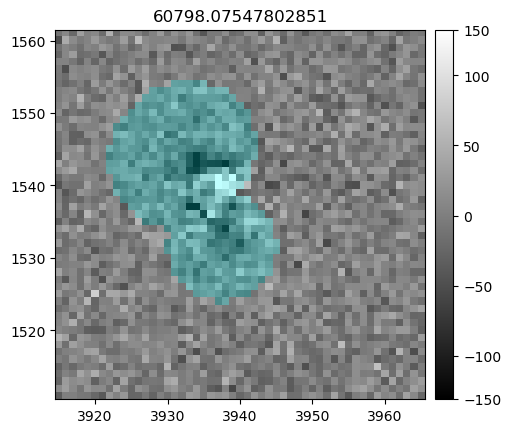

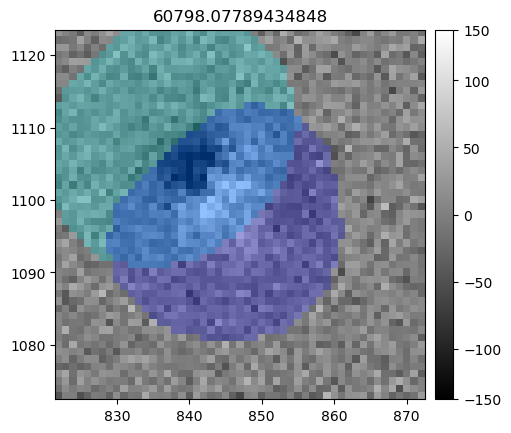

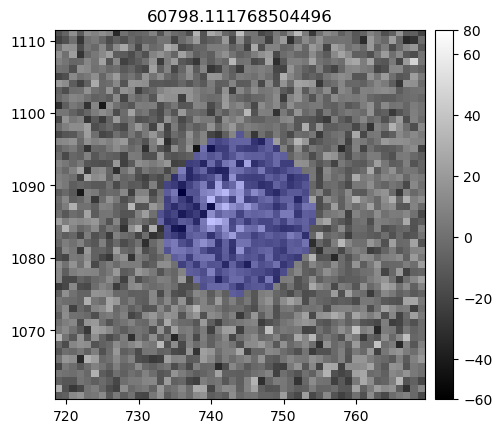

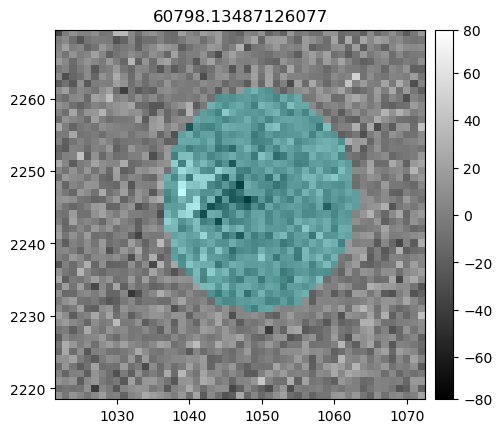

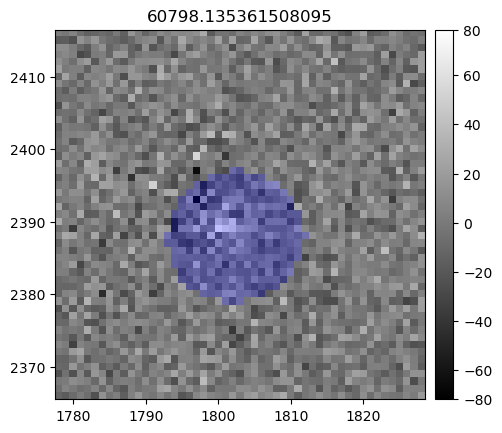

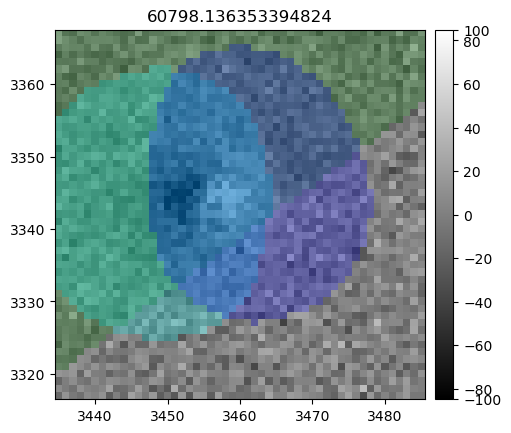

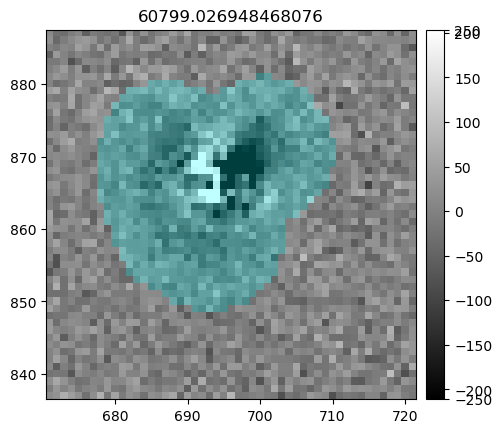

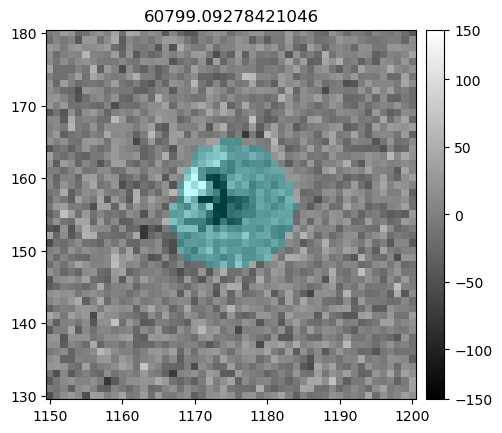

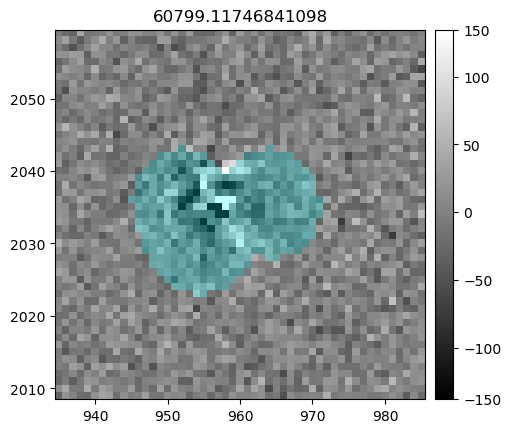

In [41]:
dataset_type = "difference_image"
# dataset_type = "visit_image"

for i, row in lc.iterrows():
    print(row["visit"], row["detector"])
    try:
        cutout = cutout_image(butler, ra=row["coord_ra"], dec=row["coord_dec"], visit=row["visit"], detector=row["detector"], dataset_type=dataset_type)
    except FileNotFoundError as e:
        print(e)
        continue
    except ValueError as e:
        print(e)
        continue

    afw_display = afwDisplay.Display(frame=i)
    afw_display.scale("linear", "zscale")
    afw_display.mtv(cutout)
    mjd = cutout.getInfo().getVisitInfo().getDate().toAstropy().mjd
    plt.title(mjd)

72574914258796561 183.75252227917093 6.021533090472069 {'tract': 10561, 'patch': 4, 'skymap': 'lsst_cells_v1'}  
72576288648331436 183.82276515013018 6.225434371596927 {'tract': 10561, 'patch': 24, 'skymap': 'lsst_cells_v1'}  
72576426087284744 183.42572499899103 6.214620153481146 {'tract': 10561, 'patch': 26, 'skymap': 'lsst_cells_v1'}  
72576426087284754 183.40897748640762 6.268596546159569 {'tract': 10561, 'patch': 26, 'skymap': 'lsst_cells_v1'}  
72577594318389471 183.94905319426206 6.64130005971463 {'tract': 10561, 'patch': 43, 'skymap': 'lsst_cells_v1'}  
72577663037866124 183.78028178645692 6.644479238196538 {'tract': 10561, 'patch': 44, 'skymap': 'lsst_cells_v1'}  
72578350232633476 183.89441500979382 6.804184567307713 {'tract': 10561, 'patch': 54, 'skymap': 'lsst_cells_v1'}  
72579037427400819 183.8024799558616 6.915889343227354 {'tract': 10561, 'patch': 64, 'skymap': 'lsst_cells_v1'}  
72579037427400730 183.89807037732572 6.9626934954376445 {'tract': 10561, 'patch': 64, 'skymap': 'lsst_cells_v1'}  
72579037427400729 183.8909026570155 6.965729967938901 {'tract': 10561, 'patch': 64, 'skymap': 'lsst_cells_v1'}  
72579037427400732 183.7862243579003 6.987152092427406 {'tract': 10561, 'patch': 64, 'skymap': 'lsst_cells_v1'}  

In [32]:
lc.iterrows()

<generator object DataFrame.iterrows at 0x7f17bb3e1ad0>